In [1]:
# ----------------- IMPORTS -----------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# ----------------- PATHS -----------------
train_dir = '/kaggle/input/fer2013/train'
test_dir  = '/kaggle/input/fer2013/test'

eff_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



In [3]:

# ----------------- LOAD DATA -----------------
train_data = datasets.ImageFolder(train_dir, transform=eff_transform)
test_data  = datasets.ImageFolder(test_dir, transform=eff_transform)

print("Train samples:", len(train_data))
print("Test samples:", len(test_data))
print("Classes:", train_data.classes)



Train samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
class_names = train_data.classes

label_map = {
    class_names.index('angry'): 0,
    class_names.index('disgust'): 0,
    class_names.index('fear'): 1,
    class_names.index('happy'): 2,
    class_names.index('neutral'): 3,
    class_names.index('sad'): 4,
    class_names.index('surprise'): 5
}

new_class_names = [
    'angry+disgust', 'fear', 'happy',
    'neutral', 'sad', 'surprise'
]


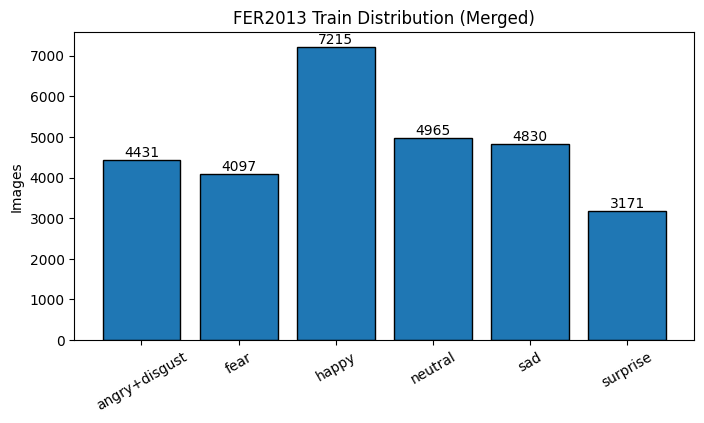

In [5]:
labels = [label for _, label in train_data.samples]
new_labels = [label_map[l] for l in labels]
counts = Counter(new_labels)

plt.figure(figsize=(8,4))
bars = plt.bar(new_class_names,
               [counts[i] for i in range(6)],
               edgecolor='black')

plt.title("FER2013 Train Distribution (Merged)")
plt.ylabel("Images")
plt.xticks(rotation=30)

for bar in bars:
    plt.text(bar.get_x()+bar.get_width()/2,
             bar.get_height(),
             int(bar.get_height()),
             ha='center', va='bottom')
plt.show()


In [6]:
for i, (path, label) in enumerate(train_data.samples):
    train_data.samples[i] = (path, label_map[label])
train_data.targets = [label_map[l] for l in train_data.targets]

for i, (path, label) in enumerate(test_data.samples):
    test_data.samples[i] = (path, label_map[label])
test_data.targets = [label_map[l] for l in test_data.targets]

set(train_data.targets), set(test_data.targets)


({0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5})

In [7]:
val_size = int(0.15 * len(train_data))
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [11]:
def get_efficientnet(num_classes=6):
    model = models.efficientnet_b0(
        weights=models.EfficientNet_B0_Weights.DEFAULT
    )

    # freeze backbone
    for param in model.features.parameters():
        param.requires_grad = False

    # unfreeze last 4 blocks
    for param in model.features[-4:].parameters():
        param.requires_grad = True

    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

model = get_efficientnet().to(device)


In [14]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)


In [16]:
patience = 5
epochs_no_improve = 0
best_val_acc = 0.0
num_epochs = 30

for epoch in range(num_epochs):

    # ---------- TRAIN ----------
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # ---------- VALIDATION ----------
    model.eval()
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Acc: {val_acc:.2f}%")

    # ---------- EARLY STOPPING ----------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_effnet.pth")
        print(" Best model saved")
    else:
        epochs_no_improve += 1
        print(f"No improvement ({epochs_no_improve}/{patience})")

    if epochs_no_improve >= patience:
        print(f"\n Early stopping triggered at epoch {epoch+1}")
        print(f" Best Validation Accuracy: {best_val_acc:.2f}%")
        break


Epoch 1/30 | Train Acc: 96.85% | Val Acc: 69.37%
 Best model saved
Epoch 2/30 | Train Acc: 96.99% | Val Acc: 69.67%
 Best model saved
Epoch 3/30 | Train Acc: 97.16% | Val Acc: 70.39%
 Best model saved
Epoch 4/30 | Train Acc: 97.25% | Val Acc: 70.25%
No improvement (1/5)
Epoch 5/30 | Train Acc: 97.36% | Val Acc: 69.74%
No improvement (2/5)
Epoch 6/30 | Train Acc: 97.30% | Val Acc: 71.23%
 Best model saved
Epoch 7/30 | Train Acc: 97.66% | Val Acc: 70.23%
No improvement (1/5)
Epoch 8/30 | Train Acc: 97.48% | Val Acc: 69.65%
No improvement (2/5)
Epoch 9/30 | Train Acc: 97.60% | Val Acc: 69.14%
No improvement (3/5)
Epoch 10/30 | Train Acc: 97.66% | Val Acc: 70.92%
No improvement (4/5)
Epoch 11/30 | Train Acc: 97.80% | Val Acc: 70.48%
No improvement (5/5)

 Early stopping triggered at epoch 11
 Best Validation Accuracy: 71.23%


In [17]:
model.load_state_dict(torch.load("best_effnet.pth"))
model.eval()

correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print("Test Accuracy:", test_acc)


Test Accuracy: 70.61855670103093


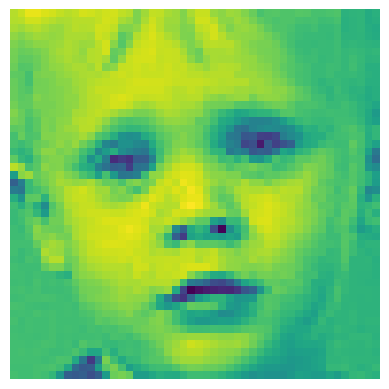

True: neutral
Pred: neutral


In [37]:
import random
def predict_random():
    idx = random.randint(0, len(test_data)-1)
    img_path, true_label = test_data.samples[idx]

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_tensor = eff_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(1).item()

    print("True:", new_class_names[true_label])
    print("Pred:", new_class_names[pred])

predict_random()
